In [1]:
from keras.models import load_model

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import tensorflow as tf

In [2]:
mlp_model = load_model("Data\my_model5.h5")

In [3]:
poa = gpd.read_file("Shape\poa_selected.gpkg")
sa1 = gpd.read_file("Shape\sa1_to_poa.gpkg")
sa2 = gpd.read_file("Shape\SA2_2021_AUST_SHP_GDA2020\SA2_2021_AUST_GDA2020.shp")
sa3 = gpd.read_file("Shape\SA3_2021_AUST_SHP_GDA2020\SA3_2021_AUST_GDA2020.shp")
lga = gpd.read_file("Shape\sa1_to_lga.gpkg")

## True POA

In [4]:
rego = pd.read_csv("Data\poa_ev.csv")
rego["POA_CODE21"] = rego["POA_CODE21"].astype(str)
true_poa_geo = poa.merge(rego, left_on="POA_CODE21", right_on="POA_CODE21", how="left").fillna(0)

In [28]:
true_poa_geo["TOTAL1"].sum()

6215.0

## SA1 Pred

In [5]:
synthetic = pd.read_csv("Data\population.csv")
synthetic["SA1_CODE21"] = synthetic["SA1_CODE21"].astype(str)
synthetic_sa1 = sa1.merge(synthetic, on="SA1_CODE21", how="right")

In [92]:
# categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Other", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
#                        "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free", "owndwell_Something Else"]

# hist_values = []
# num_bins = 10 

# sa1_list = synthetic_sa1["SA1_CODE21"].unique()
# i = 0

# for sa1_selected in sa1_list:
#     hist_values_sa1 = []
#     selected = synthetic_sa1[synthetic_sa1["SA1_CODE21"] == sa1_selected]

#     i = i + 1
#     if i % 100 == 0:  
#         print(i)

#     for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
#         hist, _ = np.histogram(selected[attribute], bins=num_bins)
#         hist_values_sa1.extend(hist)
    
#     categorical_sums = selected[categorical_columns].sum().values
#     hist_values_sa1.extend(categorical_sums)

#     hist_values.append(hist_values_sa1)

# data = np.array(hist_values)
# np.savetxt("Data\sa1_hist.csv", data, delimiter=",")

In [6]:
loaded_hist_sa1 = np.loadtxt("Data\sa1_hist.csv", delimiter=",")
sa1_list = synthetic_sa1["SA1_CODE21"].unique()
sa1_pred = mlp_model.predict(loaded_hist_sa1).flatten()
data_array_sa1 = {'SA1_CODE21': sa1_list, 'pred_evs': sa1_pred}
sa1_pred = pd.DataFrame(data_array_sa1)
sa1_pred.to_csv("Data\pred_evs_sa1", index=False)

pred_sa1_geo = sa1.merge(sa1_pred, on="SA1_CODE21", how="left").fillna(0)

365/365 [==============================] - 0s 794us/step


<Axes: >

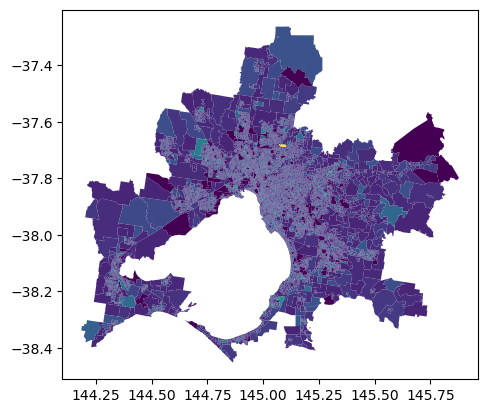

In [25]:
pred_sa1_geo.plot(column="pred_evs")

In [26]:
pred_sa1_geo["pred_evs"].sum()

6674.969332659999

## Pre POA AG

In [8]:
area_code = pd.read_csv("Data\\area_codes.csv")
area_code["SA1_CODE21"] = area_code["SA1_CODE21"].astype(str)
sa1_pred = sa1_pred.merge(area_code, on="SA1_CODE21", how="left")
agg_poa_pred = sa1_pred.groupby("POA_CODE21").sum("pred_evs").reset_index().drop(columns=["SA2_CODE21", "SA3_CODE21", "SA4_CODE21", "LGA_CODE21"])
agg_poa_pred["pred_evs"].sum()

KeyError: 'POA_CODE21'

In [9]:
area_code = pd.read_csv("Data\\area_codes.csv")
area_code["SA1_CODE21"] = area_code["SA1_CODE21"].astype(str)
sa1_pred = sa1_pred.merge(area_code, on="SA1_CODE21", how="left")

agg_poa_pred = sa1_pred.groupby("POA_CODE21").sum("pred_evs").reset_index().drop(columns=["SA2_CODE21", "SA3_CODE21", "SA4_CODE21", "LGA_CODE21"])
poa["POA_CODE21"] = poa["POA_CODE21"].astype(str)
agg_poa_pred["POA_CODE21"] = agg_poa_pred["POA_CODE21"].astype(str)
pre_ag_poa_geo = poa.merge(agg_poa_pred, on="POA_CODE21", how="left").fillna(0)

<Axes: >

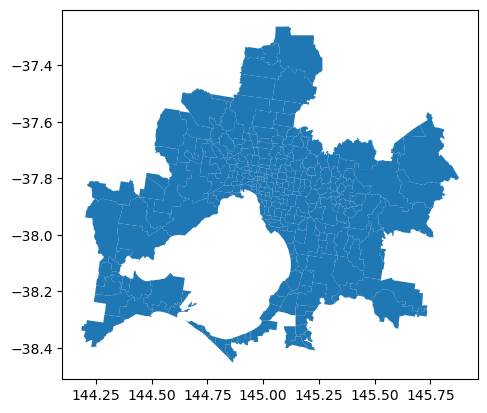

In [10]:
poa["POA_CODE21"] = poa["POA_CODE21"].astype(str)
agg_poa_pred["POA_CODE21"] = agg_poa_pred["POA_CODE21"].astype(str)
pre_ag_poa_geo = poa.merge(agg_poa_pred, on="POA_CODE21", how="left").fillna(0)
pre_ag_poa_geo.plot()

In [11]:
ag_poa_total = pre_ag_poa_geo.drop_duplicates(subset=["POA_CODE21"])["pred_evs"].sum()

## POA

In [12]:
# categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Other", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
#                        "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free", "owndwell_Something Else"]


# hist_values = []
# num_bins = 10 

# poa_list = synthetic["POA_CODE21"].unique()

# for postcode in poa_list:
#     hist_values_postcode = []
#     selected = synthetic[synthetic["POA_CODE21"] == postcode]

#     for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
#         hist, _ = np.histogram(selected[attribute], bins=num_bins)
#         hist_values_postcode.extend(hist)
    
#     categorical_sums = selected[categorical_columns].sum().values
#     hist_values_postcode.extend(categorical_sums)

#     hist_values.append(hist_values_postcode)

# data = np.array(hist_values)
# np.savetxt("Data\poa_hist.csv", data, delimiter=",")

In [13]:
poa_list = synthetic["POA_CODE21"].unique()
loaded_hist_poa = np.loadtxt("Data\poa_hist.csv", delimiter=",")
pred_poa = mlp_model.predict(loaded_hist_poa).flatten()
data_array_poa = {'POA_CODE21': poa_list, 'pred_evs': pred_poa}
pred_poa = pd.DataFrame(data_array_poa)

pred_poa["POA_CODE21"] = pred_poa["POA_CODE21"].astype(str)
pred_poa_geo = poa.merge(pred_poa, on="POA_CODE21", how="left").fillna(0)

9/9 [==============================] - 0s 847us/step


## SA2

In [14]:
# categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Other", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
#                        "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free", "owndwell_Something Else"]

# hist_values = []
# num_bins = 10 

# sa2_list = synthetic["SA2_CODE21"].unique()
# i = 0

# for sa2_selected in sa2_list:
#     hist_values_sa1 = []
#     selected = synthetic[synthetic["SA2_CODE21"] == sa2_selected]

#     i = i + 1
#     if i % 100 == 0:  
#         print(i)

#     for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
#         hist, _ = np.histogram(selected[attribute], bins=num_bins)
#         hist_values_sa1.extend(hist)
    
#     categorical_sums = selected[categorical_columns].sum().values
#     hist_values_sa1.extend(categorical_sums)

#     hist_values.append(hist_values_sa1)

# data = np.array(hist_values)
# np.savetxt("Data\sa2_hist.csv", data, delimiter=",")

In [15]:
sa2_list = synthetic["SA2_CODE21"].unique()
loaded_hist_sa2= np.loadtxt("Data\sa2_hist.csv", delimiter=",")
pred_poa = mlp_model.predict(loaded_hist_sa2).flatten()
data_array_poa = {'SA2_CODE21': sa2_list, 'pred_evs': pred_poa}
pred_sa2 = pd.DataFrame(data_array_poa)

pred_sa2["SA2_CODE21"] = pred_sa2["SA2_CODE21"].astype(str)
pred_sa2_geo = sa2.merge(pred_sa2, on="SA2_CODE21", how="right").fillna(0)

12/12 [==============================] - 0s 866us/step


# SA3

In [16]:
# categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Other", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
#                        "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free", "owndwell_Something Else"]

# hist_values = []
# num_bins = 10 

# sa3_list = synthetic["SA3_CODE21"].unique()
# i = 0

# for sa3_selected in sa3_list:
#     hist_values_sa3 = []
#     selected = synthetic[synthetic["SA3_CODE21"] == sa3_selected]

#     i = i + 1
#     if i % 100 == 0:  
#         print(i)

#     for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
#         hist, _ = np.histogram(selected[attribute], bins=num_bins)
#         hist_values_sa3.extend(hist)
    
#     categorical_sums = selected[categorical_columns].sum().values
#     hist_values_sa3.extend(categorical_sums)

#     hist_values.append(hist_values_sa3)

# data = np.array(hist_values)
# np.savetxt("Data\sa3_hist.csv", data, delimiter=",")

In [17]:
sa3_list = synthetic["SA3_CODE21"].unique()
loaded_hist_sa3= np.loadtxt("Data\sa3_hist.csv", delimiter=",")
pred_poa = mlp_model.predict(loaded_hist_sa3).flatten()
data_array_poa = {'SA3_CODE21': sa3_list, 'pred_evs': pred_poa}
pred_sa3 = pd.DataFrame(data_array_poa)

pred_sa3["SA3_CODE21"] = pred_sa3["SA3_CODE21"].astype(str)
pred_sa3_geo = sa3.merge(pred_sa3, on="SA3_CODE21", how="right").fillna(0)

2/2 [==============================] - 0s 2ms/step


## LGA

In [18]:
# categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Other", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
#                        "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free", "owndwell_Something Else"]


# hist_values = []
# num_bins = 10 

# lga_list = synthetic["LGA_CODE21"].unique()

# for lga_selected in lga_list:
#     hist_values_postcode = []
#     selected = synthetic[synthetic["LGA_CODE21"] == lga_selected]

#     for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
#         hist, _ = np.histogram(selected[attribute], bins=num_bins)
#         hist_values_postcode.extend(hist)
    
#     categorical_sums = selected[categorical_columns].sum().values
#     hist_values_postcode.extend(categorical_sums)

#     hist_values.append(hist_values_postcode)

# data = np.array(hist_values)
# np.savetxt("Data\lga_hist.csv", data, delimiter=",")

In [19]:
loaded_hist_sa1 = np.loadtxt("Data\lga_hist.csv", delimiter=",")
lga_list = synthetic["LGA_CODE21"].unique()
lga_pred = mlp_model.predict(loaded_hist_sa1).flatten()
data_array_lga = {'LGA_CODE21': lga_list, 'pred_evs': lga_pred}
lga_pred = pd.DataFrame(data_array_lga).dropna()
lga_pred.to_csv("Data\pred_evs_lga", index=False)

lga_pred["LGA_CODE21"] = lga_pred["LGA_CODE21"].astype(str)
pred_lga_geo = lga.merge(lga_pred, on="LGA_CODE21", how="right").fillna(0)

2/2 [==============================] - 0s 1ms/step


## Plotting

### Generate 

In [20]:
# combined_shape = unary_union(sa1.geometry)

In [21]:
# clipped_pred_sa2 = gpd.overlay(pred_sa2_geo, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")
# clipped_pred_sa3 = gpd.overlay(pred_sa3_geo, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")
# clipped_pred_ag_poa = gpd.overlay(pre_ag_poa_geo, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")
# clipped_pred_poa = gpd.overlay(pred_poa_geo, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")
# clipped_pred_lga = gpd.overlay(pred_lga_geo, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")

# true_poa_geo.to_file("Predictions\\true_poa.geojson", driver='GeoJSON')
# pred_sa1_geo.to_file("Predictions\pred_sa1.geojson", driver='GeoJSON')
# clipped_pred_sa2.to_file("Predictions\pred_sa2.geojson", driver='GeoJSON')
# clipped_pred_sa3.to_file("Predictions\pred_sa3.geojson", driver='GeoJSON')
# clipped_pred_ag_poa.to_file("Predictions\pred_ag_poa.geojson", driver='GeoJSON')
# clipped_pred_poa.to_file("Predictions\pred_poa.geojson", driver='GeoJSON')
# clipped_pred_lga.to_file("Predictions\pred_lga.geojson", driver='GeoJSON')

## Read In 

In [22]:
true_poa_geo = gpd.read_file("Predictions\\true_poa.geojson")
pred_sa1_geo = gpd.read_file("Predictions\pred_sa1.geojson")
clipped_pred_sa2 = gpd.read_file("Predictions\pred_sa2.geojson")
clipped_pred_sa3 = gpd.read_file("Predictions\pred_sa3.geojson")
clipped_pred_ag_poa = gpd.read_file("Predictions\pred_ag_poa.geojson")
clipped_pred_poa = gpd.read_file("Predictions\pred_poa.geojson")
clipped_pred_lga = gpd.read_file("Predictions\pred_lga.geojson")

In [23]:
print(true_poa_geo["TOTAL1"].sum())
print(pred_sa1_geo["pred_evs"].sum())
print(clipped_pred_sa2["pred_evs"].sum())
print(clipped_pred_sa3["pred_evs"].sum())
print(clipped_pred_ag_poa["pred_evs"].sum())
print(clipped_pred_poa["pred_evs"].sum())
print(clipped_pred_lga["pred_evs"].sum())

6215.0
6674.969332659999
3244.559211
2804.44354049
6844.514504909999
3098.5313897300002
1104910.4910196797


In [28]:
true_poa_geo[["POA_CODE21", "TOTAL1"]]
top_3_poa = true_poa_geo.nlargest(3, "TOTAL1")[["POA_CODE21", "TOTAL1"]]
print(top_3_poa)

    POA_CODE21  TOTAL1
181       3207    64.0
0         3000    62.0
22        3029    60.0


In [32]:
test = true_poa_geo[["POA_CODE21", "TOTAL1"]]
len(test[test["TOTAL1"] == 0])

27

In [35]:
top_3_sa1 = pred_sa1_geo.nlargest(3, "pred_evs")[["SA1_CODE21", "pred_evs"]]
print(top_3_sa1)

       SA1_CODE21  pred_evs
4657  20904121616  3.242741
6828  21103145101  2.186303
9611  21301133805  2.172898


<Figure size 1000x1000 with 0 Axes>

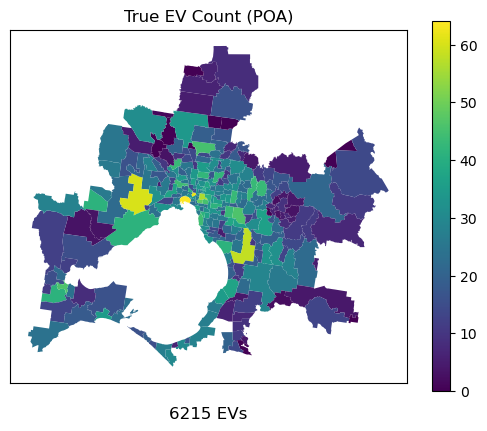

<Figure size 1000x1000 with 0 Axes>

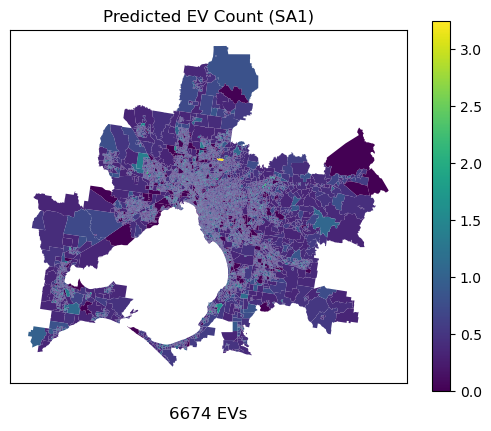

<Figure size 1000x1000 with 0 Axes>

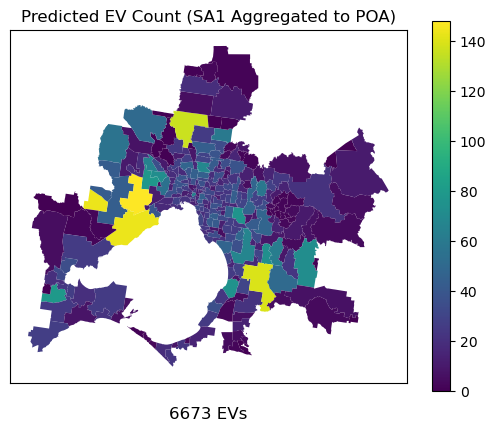

<Figure size 1000x1000 with 0 Axes>

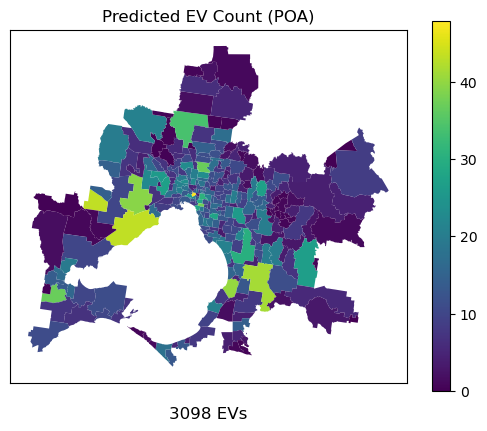

In [82]:
plot_size = 10  # Adjust this value as needed
subtitle_fontsize = 12

# Plot 1: true_poa_geo
plt.figure(figsize=(plot_size, plot_size))
ax1 = true_poa_geo.plot(column="TOTAL1", cmap='viridis', legend=True)
ax1.set_xticks([])  # Turn off x-axis ticks
ax1.set_yticks([])  # Turn off y-axis ticks
ax1.set_title("True EV Count (POA)")  # Set the title
plt.text(0.5, -0.1, f"{int(true_poa_geo['TOTAL1'].sum())} EVs", fontsize=subtitle_fontsize, transform=ax1.transAxes, ha='center')  # Add subtitle
plt.show()

# Plot 2: pred_sa1_geo
plt.figure(figsize=(plot_size, plot_size))
ax2 = pred_sa1_geo.plot(column="pred_evs", cmap='viridis', legend=True)
ax2.set_xticks([])  # Turn off x-axis ticks
ax2.set_yticks([])  # Turn off y-axis ticks
ax2.set_title("Predicted EV Count (SA1)")  # Set the title
plt.text(0.5, -0.1, f"{int(pred_sa1_geo['pred_evs'].sum())} EVs", fontsize=subtitle_fontsize, transform=ax2.transAxes, ha='center')  # Add subtitle
plt.show()

# Plot 4: clipped_pred_ag_poa
plt.figure(figsize=(plot_size, plot_size))
ax3 = clipped_pred_ag_poa.plot(column="pred_evs", cmap='viridis', legend=True)
ax3.set_xticks([])  # Turn off x-axis ticks
ax3.set_yticks([])  # Turn off y-axis ticks
ax3.set_title("Predicted EV Count (SA1 Aggregated to POA)")  # Set the title
plt.text(0.5, -0.1, f"{int(ag_poa_total)} EVs", fontsize=subtitle_fontsize, transform=ax3.transAxes, ha='center')  # Add subtitle
plt.show()

# Plot 5: clipped_pred_poa
plt.figure(figsize=(plot_size, plot_size))
ax4 = clipped_pred_poa.plot(column="pred_evs", cmap='viridis', legend=True)
ax4.set_xticks([])  # Turn off x-axis ticks
ax4.set_yticks([])  # Turn off y-axis ticks
ax4.set_title("Predicted EV Count (POA)")  # Set the title
plt.text(0.5, -0.1, f"{int(clipped_pred_poa['pred_evs'].sum())} EVs", fontsize=subtitle_fontsize, transform=ax4.transAxes, ha='center')  # Add subtitle
plt.show()

# # Plot 5: pred_sa1_geo
# plt.figure(figsize=(plot_size, plot_size))
# ax2 = clipped_pred_lga.plot(column="pred_evs", cmap='viridis', legend=True)
# ax2.set_xticks([])  # Turn off x-axis ticks
# ax2.set_yticks([])  # Turn off y-axis ticks
# ax2.set_title("Predicted SA1 Geo Data")  # Set the title
# plt.show()

# # Plot 3: pred_sa2_geo
# plt.figure(figsize=(plot_size, plot_size))
# ax2 = clipped_pred_sa2.plot(column="pred_evs", cmap='viridis', legend=True)
# ax2.set_xticks([])  # Turn off x-axis ticks
# ax2.set_yticks([])  # Turn off y-axis ticks
# ax2.set_title("Predicted EV Count (SA2)")  # Set the title
# plt.show()

